# Willow Creek - Jun 15, 2019 - File 3

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


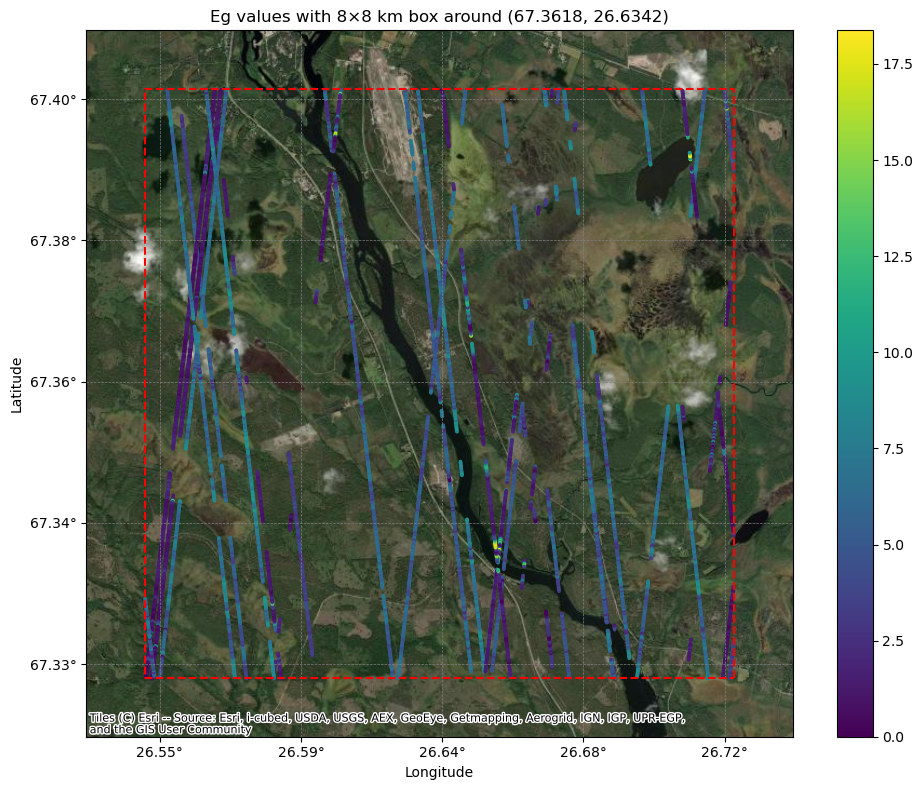

In [1]:
from scripts.track_pairs import *
from scripts.show_tracks import *

dirpaths = ['../data_store/data/sodankyla_full/']
all_coords = [(26.634154,67.361833)]
elevs = [185]
# file_nums = [[0]]

# big_df = pd.DataFrame()

# for dirpath, coords, e, f in zip(dirpaths, all_coords, elevs, file_nums):
for dirpath, coords, e in zip(dirpaths, all_coords, elevs):

    all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
    f = np.arange(len(all_ATL03))
    # print(f)

    big_df = show_tracks([all_ATL03[i] for i in f], [all_ATL08[i] for i in f], coords, altitude=e, c='Eg', CBAR=None, gtx=[1,3,5],
                         landcover='forest',rebinned=15, sat_flag=1, DW=0, w=4, h=4)
        # big_df = pd.concat([big_df,df], ignore_index=True)
    # print(big_df)
    
    # vmin = 0
    # vmax = big_df['Eg'].max()
    
    # show_colorbar(cmap='viridis', vmin=vmin, vmax=vmax, label='Eg')
    
    # map_ = plot_on_folium(big_df, c='Eg', background = 'OpenStreetMap')
    # map_.save('icesat_ojp_segments.html')
    # from IPython.display import display
    # display(map_)

vmin = 0
vmax = big_df['Eg'].max()
plot_static_map_with_box(big_df, coords, c='Eg', cmap='viridis', vmin=vmin, vmax=vmax, w=4, h=4)#, save='old_jack_pine_nonsnowy')

/home/s1803229/work/scripts/show_tracks.py:110: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_web.plot(ax=ax, column=c, cmap=cmap, markersize=3, legend=True, vmin=vmin, vmax=vmax)


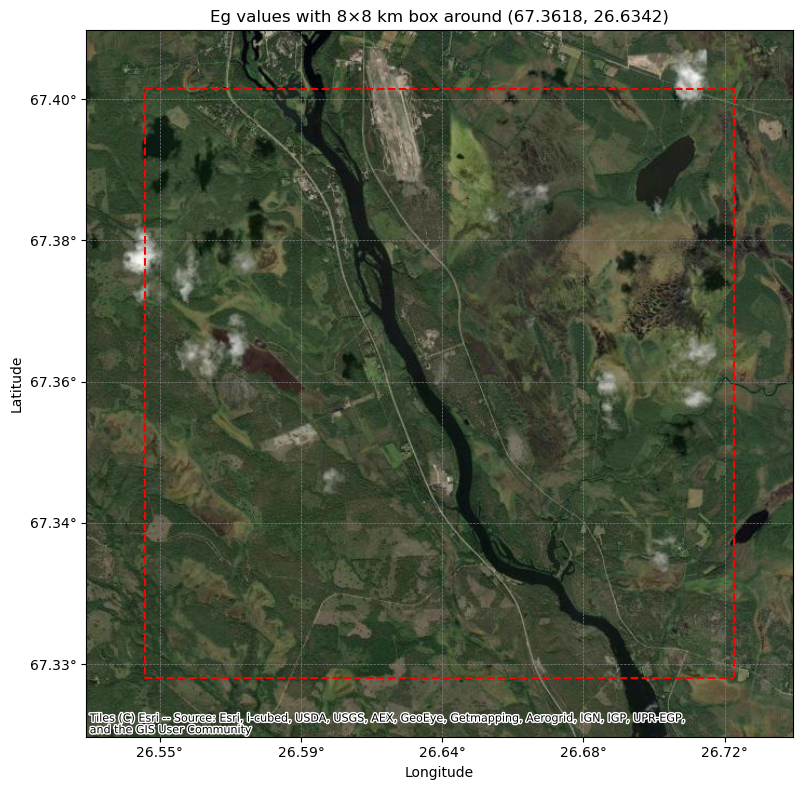

In [3]:
from scripts.track_pairs import *
from scripts.show_tracks import *

dirpaths = ['../data_store/data/sodankyla_full/']
all_coords = [(26.634154,67.361833)]
elevs = [185]
# file_nums = [[0]]

# big_df = pd.DataFrame()

# for dirpath, coords, e, f in zip(dirpaths, all_coords, elevs, file_nums):
for dirpath, coords, e in zip(dirpaths, all_coords, elevs):

    all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
    # f = np.arange(len(all_ATL03))
    f = [0]
    # print(f)

    big_df = show_tracks([all_ATL03[i] for i in f], [all_ATL08[i] for i in f], coords, altitude=e, c='Eg', CBAR=None, gtx=[1,3,5],
                         landcover='forest',rebinned=15, sat_flag=1, DW=0, w=4, h=4)
        # big_df = pd.concat([big_df,df], ignore_index=True)
    # print(big_df)
    
    # vmin = 0
    # vmax = big_df['Eg'].max()
    
    # show_colorbar(cmap='viridis', vmin=vmin, vmax=vmax, label='Eg')
    
    # map_ = plot_on_folium(big_df, c='Eg', background = 'OpenStreetMap')
    # map_.save('icesat_ojp_segments.html')
    # from IPython.display import display
    # display(map_)

vmin = 0
vmax = big_df['Eg'].max()
plot_static_map_with_box(big_df, coords, c='Eg', cmap='viridis', vmin=vmin, vmax=vmax, w=4, h=4)#, save='old_jack_pine_nonsnowy')

# Overview OJP/Underc/WillowCreek